In [1]:
from geoband.API import *
#GetCompasData('SBJ_2007_001', '1', '01.운영이력.csv')
#GetCompasData('SBJ_2007_001', '34', '34.고양시_행정경계(행정동기준).geojson')
#GetCompasData('SBJ_2007_001', '2', '02.자전거스테이션.csv')
#GetCompasData('SBJ_2007_001', '8', '08.행정경계(시군구).geojson')
#GetCompasData('SBJ_2007_001', '7', '07.인구통계.csv')

In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
from haversine import haversine
import geojson
from shapely.geometry import shape, GeometryCollection, Point
from datetime import datetime, timedelta
from tqdm import tqdm
import geopandas as gpd

import json
import folium

/opt/app-root/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
%ls

01.운영이력.csv              34.고양시_행정경계(행정동기준).geojson
02.자전거스테이션.csv        피프틴을탄문돌이.ipynb
07.인구통계.csv              NanumBarunGothic.ttf
08.행정경계(시군구).geojson  new_station.geojson


# 데이터 전처리 (스테이션 위치 정보)

In [4]:
df_2 = pd.read_csv('02.자전거스테이션.csv')
df_2.head()

,Station_ID,STATION_NAME,거치대 수량,위도,경도
0,101,어울림마을 701동 앞,20,37.654775,126.834584
1,103,대림e-편한세상106동,20,37.660442,126.840377
2,104,탄현마을8단지,25,37.698523,126.766042
3,105,KT 덕양지사 앞,20,37.655244,126.839261
4,106,원당역 앞 공영주차장,30,37.653410,126.842530


In [5]:
geo_str_34 = geojson.load(open('34.고양시_행정경계(행정동기준).geojson',encoding='utf-8'))
df_34=gpd.read_file('34.고양시_행정경계(행정동기준).geojson')
df_34.head()

,행정동코드,행정동명,geometry
0,3110151,주교동,"MULTIPOLYGON (((126.83514 37.67683, 126.83517 ..."
1,3110152,원신동,"MULTIPOLYGON (((126.84983 37.68986, 126.84996 ..."
2,3110153,흥도동,"MULTIPOLYGON (((126.87615 37.64768, 126.87562 ..."
3,3110154,성사1동,"MULTIPOLYGON (((126.84898 37.66872, 126.84915 ..."
4,3110155,성사2동,"MULTIPOLYGON (((126.83502 37.65491, 126.83527 ..."


In [6]:
# 스테이션에 해당되는 동 위치 추가
point= [Point(xy) for xy in zip(df_2.경도, df_2.위도)]  # 모든 스테이션의 (경도, 위도)를 가지고 있음

dong=[]
id=[]

for feature in geo_str_34['features']:                      
    polygon = shape(feature['geometry'])               # geostr내의 행정동 좌표값을 각각 가져와서 polygon 형태로 만듦
    for p in range(len(point)):
        if polygon.contains(point[p]):                    # 행정동이 스테이션의 (경도, 위도)를 가지고 있다면
            dong.append(feature['properties']['행정동명'])  # 그 행정동의 이름을 dong에 넣고
            id.append(df_2['Station_ID'][p])                # 스테이션의 이름을 id에 넣음
        
st_d=pd.DataFrame([dong,id])      # 스테이션별 좌표와, 스테이션이 위치한 동의 이름으로 df만듦
st_d=st_d.T
st_d.columns=['dong','Station_ID']
station_dong=st_d[['Station_ID','dong']]
station_dong.head()

,Station_ID,dong
0,146,주교동
1,170,원신동
2,171,원신동
3,172,원신동
4,173,원신동


In [7]:
# 컬럼명 정리
station_dong=pd.merge(df_2,st_d,on='Station_ID')

station_dong=station_dong[['dong','Station_ID','STATION_NAME','거치대 수량','경도','위도']]
station_dong

,dong,Station_ID,STATION_NAME,거치대 수량,경도,위도
0,성사2동,101,어울림마을 701동 앞,20,126.834584,37.654775
1,성사1동,103,대림e-편한세상106동,20,126.840377,37.660442
2,탄현동,104,탄현마을8단지,25,126.766042,37.698523
3,성사1동,105,KT 덕양지사 앞,20,126.839261,37.655244
4,성사1동,106,원당역 앞 공영주차장,30,126.842530,37.653410
...,...,...,...,...,...,...
159,송산동,350,★하이파크5단지 502동앞 버스정류장,20,126.753089,37.697867
160,탄현동,351,◆일산에듀포레 푸르지오,40,126.767231,37.702259
161,대화동,352,◆꿈에그린203동앞,40,126.749244,37.666425
162,대화동,353,◆꿈에그린106동앞,40,126.750784,37.666720


# 동별 이용량 Top 10 선별

In [8]:
# 데이터 호출
df_1 = pd.read_csv('01.운영이력.csv')
df_1.head()

,LEAS_NO,LEAS_STAT,LEAS_DATE,LEAS_STATION,LEAS_DEF_NO,RTN_DATE,RTN_STATION,RTN_DEF_NO,TRNV_QTY,MEMB_DIV,MEMB_NO,TEMP_MEMB_NO,BIKE_TAG,RTN_PROCESS
0,15945541,2,2017-01-01 00:00:41,213,18,2017-01-01 00:13:52,260,17,0.0,6,164203,0.0,1A844000000BB7,NaN
1,15945542,2,2017-01-01 00:01:03,231,4,2017-01-01 00:50:24,231,17,31039.0,1,187551,0.0,1A844000000494,NaN
2,15945543,2,2017-01-01 00:01:50,119,14,2017-01-01 01:01:50,0,0,NaN,12,168994,0.0,1A844000000533,1.0
3,15945544,2,2017-01-01 00:02:09,121,17,2017-01-01 00:15:58,133,14,15490.0,12,183971,0.0,1A844000000731,NaN
4,15945545,2,2017-01-01 00:03:32,320,29,2017-01-01 00:18:44,259,27,0.0,12,167475,0.0,1A84400000F343,NaN


In [9]:
#대여 일시를 월별로 분류
df_1['LEAS_MONTH_ONLY']= df_1['LEAS_DATE'].map(lambda x: x.split(' ')[0][:-3])

#반납 일시를 월별로 분류
df_1['RTN_MONTH_ONLY']= df_1['RTN_DATE'].map(lambda x: x.split(' ')[0][:-3])
df_1.head()

,LEAS_NO,LEAS_STAT,LEAS_DATE,LEAS_STATION,LEAS_DEF_NO,RTN_DATE,RTN_STATION,RTN_DEF_NO,TRNV_QTY,MEMB_DIV,MEMB_NO,TEMP_MEMB_NO,BIKE_TAG,RTN_PROCESS,LEAS_MONTH_ONLY,RTN_MONTH_ONLY
0,15945541,2,2017-01-01 00:00:41,213,18,2017-01-01 00:13:52,260,17,0.0,6,164203,0.0,1A844000000BB7,NaN,2017-01,2017-01
1,15945542,2,2017-01-01 00:01:03,231,4,2017-01-01 00:50:24,231,17,31039.0,1,187551,0.0,1A844000000494,NaN,2017-01,2017-01
2,15945543,2,2017-01-01 00:01:50,119,14,2017-01-01 01:01:50,0,0,NaN,12,168994,0.0,1A844000000533,1.0,2017-01,2017-01
3,15945544,2,2017-01-01 00:02:09,121,17,2017-01-01 00:15:58,133,14,15490.0,12,183971,0.0,1A844000000731,NaN,2017-01,2017-01
4,15945545,2,2017-01-01 00:03:32,320,29,2017-01-01 00:18:44,259,27,0.0,12,167475,0.0,1A84400000F343,NaN,2017-01,2017-01


In [10]:
# 반납 스테이션 0, 999, 998 제외
case = df_1['RTN_STATION'].isin([0, 999, 998, 992])
df_1=df_1[~case]
df_1.head()

,LEAS_NO,LEAS_STAT,LEAS_DATE,LEAS_STATION,LEAS_DEF_NO,RTN_DATE,RTN_STATION,RTN_DEF_NO,TRNV_QTY,MEMB_DIV,MEMB_NO,TEMP_MEMB_NO,BIKE_TAG,RTN_PROCESS,LEAS_MONTH_ONLY,RTN_MONTH_ONLY
0,15945541,2,2017-01-01 00:00:41,213,18,2017-01-01 00:13:52,260,17,0.0,6,164203,0.0,1A844000000BB7,NaN,2017-01,2017-01
1,15945542,2,2017-01-01 00:01:03,231,4,2017-01-01 00:50:24,231,17,31039.0,1,187551,0.0,1A844000000494,NaN,2017-01,2017-01
3,15945544,2,2017-01-01 00:02:09,121,17,2017-01-01 00:15:58,133,14,15490.0,12,183971,0.0,1A844000000731,NaN,2017-01,2017-01
4,15945545,2,2017-01-01 00:03:32,320,29,2017-01-01 00:18:44,259,27,0.0,12,167475,0.0,1A84400000F343,NaN,2017-01,2017-01
5,15945546,2,2017-01-01 00:03:40,309,8,2017-01-01 00:10:50,210,3,0.0,99,0,3185081.0,1A84400000F505,NaN,2017-01,2017-01


In [11]:
# 대여량 반납량 카운트 계산
leas_count=df_1.groupby(['LEAS_STATION', 'LEAS_MONTH_ONLY']).count().max(axis=1).reset_index()
leas_count.columns=['Station_ID','DATE','LEAS_COUNT']

rtn_count=df_1.groupby(['RTN_STATION', 'RTN_MONTH_ONLY']).count().max(axis=1).reset_index()
rtn_count.columns=['Station_ID','DATE','RTN_COUNT']

In [12]:
# 대여량 반납량 카운트 컬럼 정리
station_leas_rtn=pd.merge(leas_count,station_dong[['Station_ID','dong','STATION_NAME']],on='Station_ID',how='left')
station_leas_rtn=pd.merge(station_leas_rtn,rtn_count,on=['Station_ID','DATE'],how='left')

station_leas_rtn=station_leas_rtn[['dong','Station_ID','DATE','LEAS_COUNT','RTN_COUNT']]
station_leas_rtn.head()

,dong,Station_ID,DATE,LEAS_COUNT,RTN_COUNT
0,성사2동,101,2017-01,73,109.0
1,성사2동,101,2017-02,68,89.0
2,성사2동,101,2017-03,186,204.0
3,성사2동,101,2017-04,282,372.0
4,성사2동,101,2017-05,385,500.0


In [13]:
# 동별 대여량, 반납량 카운트 계산 / 동별 전체 이용량

sum_of_use = station_leas_rtn[station_leas_rtn['DATE']=='2019-11'].groupby('dong')[['LEAS_COUNT', 'RTN_COUNT']].sum()
sum_of_use['use']=0
for i in range(len(sum_of_use)):
    sum_of_use['use'][i] = sum_of_use['LEAS_COUNT'][i] + sum_of_use['RTN_COUNT'][i]

sum_of_use.reset_index(inplace=True)

sum_of_use.head()

,dong,LEAS_COUNT,RTN_COUNT,use
0,능곡동,141,125.0,266
1,대화동,4263,3883.0,8146
2,마두1동,4795,4594.0,9389
3,마두2동,4049,3970.0,8019
4,백석1동,3164,3004.0,6168


- 동별 사용량 비교를 위해 'DATE'가 '2019-11'인 최신의 데이터만을 정제
    - 비교적 최신에 설치된 스테이션의 이용량을 함께 비교하기 위함

In [14]:
# 대여량 등수
print('대여량 등수')
print(sum_of_use.sort_values(by='LEAS_COUNT', ascending=False).head(10))
print('-'*50)
# 반납량 등수
print('반납량 등수')
print(sum_of_use.sort_values(by='RTN_COUNT', ascending=False).head(10))
print('-'*50)
# 대여+반납량 등수
print('대여량+반납량 등수')
print(sum_of_use.sort_values(by='use',ascending=False).head(10))

대여량 등수
    dong  LEAS_COUNT  RTN_COUNT    use
16  장항2동        9264    10479.0  19743
19  주엽1동        5200     4975.0  10175
2   마두1동        4795     4594.0   9389
17  정발산동        4419     4291.0   8710
14  일산3동        4265     4416.0   8681
1    대화동        4263     3883.0   8146
3   마두2동        4049     3970.0   8019
21   중산동        3708     2979.0   6687
20  주엽2동        3529     3495.0   7024
4   백석1동        3164     3004.0   6168
--------------------------------------------------
반납량 등수
    dong  LEAS_COUNT  RTN_COUNT    use
16  장항2동        9264    10479.0  19743
19  주엽1동        5200     4975.0  10175
2   마두1동        4795     4594.0   9389
14  일산3동        4265     4416.0   8681
17  정발산동        4419     4291.0   8710
3   마두2동        4049     3970.0   8019
1    대화동        4263     3883.0   8146
20  주엽2동        3529     3495.0   7024
4   백석1동        3164     3004.0   6168
21   중산동        3708     2979.0   6687
--------------------------------------------------
대여량+반납량 등수
    dong  LEAS_

# 동별 인구수 증가 Top 10

In [15]:
# 데이터정제
df_7=pd.read_csv('07.인구통계.csv')

df_7['총인구수'] = [df_7['총인구수'][i].replace(',','') for i in range(len(df_7))]
for i in range(len(df_7)):
    if len(df_7['행정구역'][i].split(' ')) >= 4:
        df_7['행정구역'][i] = df_7['행정구역'][i].split(' ')[3][:-12]
        
df_7.tail()

,행정구역,조회기준,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율
1579,송산동,2019년08월,50610,"18,390",2.75,"24,983","25,627",0.97
1580,송산동,2019년09월,50694,"18,404",2.75,"25,025","25,669",0.97
1581,송산동,2019년10월,50660,"18,398",2.75,"25,020","25,640",0.98
1582,송산동,2019년11월,50865,"18,480",2.75,"25,112","25,753",0.98
1583,송산동,2019년12월,51060,"18,555",2.75,"25,195","25,865",0.97


In [16]:
#전체 동의 인구증가율 확인하기
dong=['주교동', '원신동', '흥도동', '성사1동', '성사2동',
       '효자동', '창릉동', '고양동', '관산동', '능곡동', '화정1동', '화정2동',
       '행주동', '행신1동', '행신2동', '행신3동', '화전동', '대덕동', '식사동', '중산동', '정발산동',
       '풍산동', '백석1동', '백석2동', '마두1동', '마두2동', '장항1동', '장항2동', '고봉동',
       '일산1동', '일산2동', '일산3동', '탄현동', '주엽1동', '주엽2동', '대화동', '송포동', '송산동']


df_7_dong = [df_7[df_7['행정구역'].str.contains(dong)] for dong in dong]

name = []
fluctuation = []
for i in range(len(df_7_dong)):
    new_df = df_7_dong[i]
    downdate = float(new_df.iloc[0,2]) # 2017년 1월
    update = float(new_df.iloc[35,2])  # 2019년 12월
    name.append(new_df.iloc[0,0])
    fluctuation.append(update-downdate) # 2017년 1월 ~ 2019년 12월까지

pop_fluctuation=pd.DataFrame([name,fluctuation]).T
pop_fluctuation.columns=['dong','fluctuation']

pop_fluctuation.sort_values(by='fluctuation',ascending=False, inplace=True)
pop_fluctuation.reset_index(inplace=True, drop=True)

pop_fluctuation.head(10)

,dong,fluctuation
0,화전동,13450
1,흥도동,11568
2,창릉동,6988
3,장항1동,6332
4,원신동,4674
5,송포동,3676
6,중산동,3039
7,고봉동,2920
8,송산동,2766
9,탄현동,2759


# 동별 출퇴근 인구수 Top 10

In [17]:
# 데이터 호출
df_1 = pd.read_csv('01.운영이력.csv')
df_2 = pd.read_csv('02.자전거스테이션.csv')

geo_str_34 = geojson.load(open('34.고양시_행정경계(행정동기준).geojson',encoding='utf-8'))

In [18]:
# 스테이션 + 동위치
point= [Point(xy) for xy in zip(df_2.경도, df_2.위도)]  # 모든 스테이션의 (경도, 위도)를 가지고 있음

dong=[]
id=[]

for feature in geo_str_34['features']:                      
    polygon = shape(feature['geometry'])               # geostr내의 행정동 좌표값을 각각 가져와서 polygon 형태로 만듦
    for p in range(len(point)):
        if polygon.contains(point[p]):                    # 행정동이 스테이션의 (경도, 위도)를 가지고 있다면
            dong.append(feature['properties']['행정동명'])  # 그 행정동의 이름을 dong에 넣고
            id.append(df_2['Station_ID'][p])                # 스테이션의 이름을 id에 넣음
        
st_d=pd.DataFrame([dong,id])      # 스테이션별 좌표와, 스테이션이 위치한 동의 이름으로 df만듦
st_d=st_d.T
st_d.columns=['dong','Station_ID']
station_dong=st_d[['Station_ID','dong']]
station_dong.head()

,Station_ID,dong
0,146,주교동
1,170,원신동
2,171,원신동
3,172,원신동
4,173,원신동


In [19]:
# 대여스테이션 + 동별 위치
Leas = station_dong
Leas.rename(columns={
    'Station_ID':'LEAS_STATION',
    'dong':'LEAS_dong'}, inplace=True)
Leas.head()

,LEAS_STATION,LEAS_dong
0,146,주교동
1,170,원신동
2,171,원신동
3,172,원신동
4,173,원신동


In [20]:
df_1 = pd.merge(df_1, Leas, on='LEAS_STATION')

In [21]:
# 반납스테이션 + 동별 위치
Rtn = station_dong
Rtn.rename(columns={
    'LEAS_STATION':'RTN_STATION',
    'LEAS_dong':'RTN_dong'}, inplace=True)
Rtn.head()

,RTN_STATION,RTN_dong
0,146,주교동
1,170,원신동
2,171,원신동
3,172,원신동
4,173,원신동


In [22]:
df_1 = pd.merge(df_1, Rtn, on='RTN_STATION')
df_1.head()

,LEAS_NO,LEAS_STAT,LEAS_DATE,LEAS_STATION,LEAS_DEF_NO,RTN_DATE,RTN_STATION,RTN_DEF_NO,TRNV_QTY,MEMB_DIV,MEMB_NO,TEMP_MEMB_NO,BIKE_TAG,RTN_PROCESS,LEAS_dong,RTN_dong
0,15945541,2,2017-01-01 00:00:41,213,18,2017-01-01 00:13:52,260,17,0.0,6,164203,0.0,1A844000000BB7,NaN,마두1동,장항2동
1,15964190,2,2017-01-06 19:53:02,213,21,2017-01-06 20:08:02,260,19,0.0,36,3781,0.0,1A84400000F516,NaN,마두1동,장항2동
2,15967369,2,2017-01-07 17:43:58,213,21,2017-01-07 18:02:50,260,12,0.0,3,188080,0.0,1A844000000930,NaN,마두1동,장항2동
3,16058374,2,2017-02-19 17:00:00,213,8,2017-02-19 17:47:13,260,23,0.0,3,119748,0.0,1A84400000F6DB,NaN,마두1동,장항2동
4,16077431,2,2017-02-27 00:31:20,213,16,2017-02-27 00:43:31,260,12,0.0,3,188408,0.0,1A844000000A0A,NaN,마두1동,장항2동


In [23]:
# 시계열 데이터 처리
df_1['LEAS_DATE']=df_1.LEAS_DATE.astype('datetime64')
df_1['RTN_DATE']=df_1.RTN_DATE.astype('datetime64')

In [24]:
df_1['대여일']=df_1['LEAS_DATE'].dt.day
df_1['대여요일']=df_1['LEAS_DATE'].dt.dayofweek
df_1['대여시간']=df_1['LEAS_DATE'].dt.hour
df_1['반납시간']=df_1['RTN_DATE'].dt.hour

In [25]:
# 요일별 이용량

use_by_dayoweek = df_1.groupby('대여요일').size()
use_by_dayoweek.index = "월 화 수 목 금 토 일".split()
use_by_dayoweek

월    384384
화    392813
수    395638
목    394302
금    411335
토    401458
일    364493
dtype: int64

In [26]:
# 주말 평일 평균 이용량 비교

mean_weekday = use_by_dayoweek.loc["월 화 수 목 금".split()].mean()
mean_weekend = use_by_dayoweek.loc['토 일'.split()].mean()

pd.Series(data=[mean_weekday, mean_weekend],
         index=["평일","주말"])

평일    395694.4
주말    382975.5
dtype: float64

In [27]:
# 시간에 따른 평일 이용량

pd.DataFrame(data={
    '대여량':df_1[df_1["대여요일"].isin(set(range(0,5)))].groupby('대여시간').size()//5,
    '반납량':df_1[df_1["대여요일"].isin(set(range(0,5)))].groupby('반납시간').size()//5 
})

,대여량,반납량
0,11286,12584
1,8215,9005
2,5422,6194
3,3032,3545
4,2270,2381
5,3588,3505
6,7461,6471
7,16072,13883
8,28713,28121
9,15072,15944


In [28]:
# 시간에 따른 동별 이용량(평일, 대여)

pvt_table = (df_1[df_1['대여요일'].isin(set(range(0, 5)))].groupby(['LEAS_dong', '대여시간']).size()//5).unstack()
pvt_table

대여시간,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
LEAS_dong,,,,,,,,,,,,,,,,,,,,,
능곡동,41,43,18,12,8,4,18,39,94,27,...,20,19,21,37,108,44,41,28,37,33
대화동,829,595,416,230,151,238,493,1470,2443,1223,...,1229,1575,2071,2394,2525,1874,1574,1714,1578,1094
마두1동,693,538,305,137,99,236,442,1037,2142,1183,...,1285,1945,2106,2236,2886,2235,1750,1710,2026,1115
마두2동,561,396,234,123,142,234,290,760,1867,1138,...,1244,1512,1698,2003,2462,1971,1762,1632,1685,899
백석1동,409,355,227,133,85,162,402,668,1474,783,...,800,972,1230,1575,1961,1495,1439,1411,1056,591
백석2동,284,242,175,106,77,170,201,450,1267,681,...,730,821,1074,1056,1572,1083,923,849,619,455
삼송동,71,45,20,15,11,26,73,40,138,92,...,133,154,129,177,284,226,181,177,181,163
성사1동,83,32,16,12,6,11,34,62,101,33,...,54,63,58,85,154,95,82,71,63,73
성사2동,41,41,26,25,15,9,8,18,41,20,...,32,40,40,61,160,78,88,67,47,56


In [29]:
# 시간에 따른 동별 이용량(평일, 반납)

pvt_table = (df_1[df_1['대여요일'].isin(set(range(0, 5)))].groupby(['LEAS_dong', '반납시간']).size()//5).unstack()
pvt_table

# 대여량 반납량의 차이가 크지않으므로 대여량=이용량으로 가정하여 진행

반납시간,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
LEAS_dong,,,,,,,,,,,,,,,,,,,,,
능곡동,41,43,29,9,11,5,16,31,93,32,...,16,22,21,33,90,59,37,34,34,37
대화동,920,653,476,265,168,234,370,1288,2381,1329,...,1181,1438,1872,2358,2594,1980,1640,1737,1756,1243
마두1동,788,591,357,162,107,192,435,904,2075,1239,...,1246,1790,1831,2398,2831,2353,1782,1741,2162,1313
마두2동,625,436,284,135,116,245,285,673,1734,1191,...,1200,1407,1616,1960,2407,2053,1801,1686,1814,1069
백석1동,461,373,261,149,97,154,354,602,1438,809,...,764,882,1168,1446,1982,1524,1498,1371,1266,722
백석2동,336,263,191,128,76,146,199,402,1164,720,...,724,687,919,1199,1493,1148,920,905,753,548
삼송동,82,49,23,12,19,25,70,37,122,86,...,130,146,132,163,250,255,195,191,197,176
성사1동,93,39,22,13,8,12,30,44,98,40,...,53,65,60,75,144,105,79,80,71,74
성사2동,45,46,28,26,16,12,9,14,37,21,...,31,44,39,50,151,75,82,85,58,53


In [30]:
# 시간대별 이용량을 하루 평균으로 나타내어 스테이션의 공급이 원할한지 파악해보고자 함
pvt_table = (df_1[df_1['대여요일'].isin(set(range(0, 5)))].groupby(['LEAS_dong','대여시간']).size()/5/156).unstack() #평일 5일, 3년 156주(1년 52주)
pvt_table

대여시간,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
LEAS_dong,,,,,,,,,,,,,,,,,,,,,
능곡동,0.267949,0.280769,0.120513,0.076923,0.053846,0.029487,0.115385,0.251282,0.602564,0.178205,...,0.130769,0.126923,0.134615,0.239744,0.694872,0.283333,0.265385,0.180769,0.239744,0.212821
대화동,5.315385,3.819231,2.666667,1.478205,0.970513,1.526923,3.162821,9.426923,15.661538,7.841026,...,7.882051,10.098718,13.278205,15.350000,16.191026,12.016667,10.089744,10.988462,10.120513,7.014103
마두1동,4.446154,3.451282,1.958974,0.880769,0.638462,1.514103,2.834615,6.647436,13.732051,7.583333,...,8.238462,12.469231,13.501282,14.334615,18.500000,14.326923,11.221795,10.966667,12.988462,7.150000
마두2동,3.596154,2.542308,1.502564,0.788462,0.911538,1.502564,1.860256,4.871795,11.973077,7.300000,...,7.974359,9.696154,10.888462,12.842308,15.783333,12.637179,11.297436,10.466667,10.802564,5.766667
백석1동,2.624359,2.279487,1.457692,0.856410,0.550000,1.041026,2.578205,4.283333,9.451282,5.024359,...,5.133333,6.232051,7.887179,10.096154,12.574359,9.588462,9.228205,9.050000,6.774359,3.789744
백석2동,1.824359,1.556410,1.126923,0.684615,0.493590,1.089744,1.291026,2.888462,8.126923,4.369231,...,4.684615,5.265385,6.888462,6.771795,10.078205,6.946154,5.917949,5.446154,3.969231,2.920513
삼송동,0.455128,0.292308,0.129487,0.100000,0.075641,0.167949,0.469231,0.258974,0.885897,0.589744,...,0.853846,0.989744,0.828205,1.137179,1.821795,1.451282,1.162821,1.137179,1.164103,1.044872
성사1동,0.534615,0.205128,0.107692,0.082051,0.039744,0.074359,0.221795,0.397436,0.647436,0.216667,...,0.351282,0.408974,0.374359,0.546154,0.989744,0.612821,0.529487,0.460256,0.408974,0.467949
성사2동,0.266667,0.262821,0.166667,0.160256,0.100000,0.060256,0.056410,0.116667,0.264103,0.128205,...,0.210256,0.256410,0.261538,0.391026,1.030769,0.503846,0.564103,0.434615,0.306410,0.358974


In [31]:
# 출근시간(6시~9시 59분), 퇴근시간(17시~20시 59분)
com1=pvt_table[6]+pvt_table[7]+pvt_table[8]+pvt_table[9]
com2=pvt_table[17]+pvt_table[18]+pvt_table[20]
average_commute=pd.merge(com1.to_frame(name='출근'),com2.to_frame(name='퇴근'), left_index=True, right_index=True)
average_commute.reset_index(inplace=True)
average_commute.head()

,LEAS_dong,출근,퇴근
0,능곡동,1.147436,1.200000
1,대화동,36.092308,41.630769
2,마두1동,30.797436,44.056410
3,마두2동,26.005128,39.923077
4,백석1동,21.337179,31.898718


In [32]:
# 동별 스테이션 거치대 수
Station_count = pd.merge(st_d, df_2, on='Station_ID')
Station_count.drop(['위도','경도','STATION_NAME'],axis=1,inplace=True)
Station_count.sort_values(by='Station_ID').head()

,dong,Station_ID,거치대 수량
14,성사2동,101,20
11,성사1동,103,20
125,탄현동,104,25
12,성사1동,105,20
13,성사1동,106,30


In [33]:
# 동별 스테이션 개수
dong_S_c = Station_count.groupby(['dong']).sum().reset_index()
dong_S_c.rename(columns={'dong':'LEAS_dong'}, inplace=True)
dong_S_c.head()

,LEAS_dong,거치대 수량
0,능곡동,20
1,대화동,290
2,마두1동,190
3,마두2동,125
4,백석1동,245


In [34]:
# merge
average_commute = pd.merge(average_commute, dong_S_c, on='LEAS_dong')
average_commute.head()

,LEAS_dong,출근,퇴근,거치대 수량
0,능곡동,1.147436,1.200000,20
1,대화동,36.092308,41.630769,290
2,마두1동,30.797436,44.056410,190
3,마두2동,26.005128,39.923077,125
4,백석1동,21.337179,31.898718,245


In [35]:
# 자전거수 예측값 추가
average_commute['자전거'] = [i*0.31 for i in average_commute['거치대 수량']]
average_commute.head()

,LEAS_dong,출근,퇴근,거치대 수량,자전거
0,능곡동,1.147436,1.200000,20,6.20
1,대화동,36.092308,41.630769,290,89.90
2,마두1동,30.797436,44.056410,190,58.90
3,마두2동,26.005128,39.923077,125,38.75
4,백석1동,21.337179,31.898718,245,75.95


In [36]:
# 수요 공급량 간의 격차 확인

average_commute['자전거-출근'] = [round(i-j,2) for i, j in zip(average_commute['자전거'],average_commute['출근'])]
average_commute['자전거-퇴근'] = [round(i-j,2) for i, j in zip(average_commute['자전거'],average_commute['퇴근'])]
average_commute.head()

,LEAS_dong,출근,퇴근,거치대 수량,자전거,자전거-출근,자전거-퇴근
0,능곡동,1.147436,1.200000,20,6.20,5.05,5.00
1,대화동,36.092308,41.630769,290,89.90,53.81,48.27
2,마두1동,30.797436,44.056410,190,58.90,28.10,14.84
3,마두2동,26.005128,39.923077,125,38.75,12.74,-1.17
4,백석1동,21.337179,31.898718,245,75.95,54.61,44.05


In [37]:
# 출근 이용량 top 10
average_commute.sort_values(by='출근', ascending=False).reset_index(drop=True).head(10)

,LEAS_dong,출근,퇴근,거치대 수량,자전거,자전거-출근,자전거-퇴근
0,정발산동,37.052564,32.926923,135,41.85,4.80,8.92
1,주엽1동,36.761538,39.197436,155,48.05,11.29,8.85
2,대화동,36.092308,41.630769,290,89.90,53.81,48.27
3,장항2동,32.992308,101.947436,250,77.50,44.51,-24.45
4,마두1동,30.797436,44.056410,190,58.90,28.10,14.84
5,중산동,30.675641,25.082051,225,69.75,39.07,44.67
6,마두2동,26.005128,39.923077,125,38.75,12.74,-1.17
7,일산3동,24.792308,28.583333,130,40.30,15.51,11.72
8,백석1동,21.337179,31.898718,245,75.95,54.61,44.05
9,주엽2동,19.258974,30.324359,105,32.55,13.29,2.23


In [38]:
# 퇴근 이용량 top 10
average_commute.sort_values(by='퇴근', ascending=False).reset_index(drop=True).head(10)

,LEAS_dong,출근,퇴근,거치대 수량,자전거,자전거-출근,자전거-퇴근
0,장항2동,32.992308,101.947436,250,77.50,44.51,-24.45
1,마두1동,30.797436,44.056410,190,58.90,28.10,14.84
2,대화동,36.092308,41.630769,290,89.90,53.81,48.27
3,마두2동,26.005128,39.923077,125,38.75,12.74,-1.17
4,주엽1동,36.761538,39.197436,155,48.05,11.29,8.85
5,정발산동,37.052564,32.926923,135,41.85,4.80,8.92
6,백석1동,21.337179,31.898718,245,75.95,54.61,44.05
7,주엽2동,19.258974,30.324359,105,32.55,13.29,2.23
8,일산3동,24.792308,28.583333,130,40.30,15.51,11.72
9,중산동,30.675641,25.082051,225,69.75,39.07,44.67


- 위의 3가지의 기준으로 다음과 같이 각 기준의 상위 10개 동을 확인

In [39]:
use_top10=sum_of_use.sort_values(by='use',ascending=False).head(10)['dong'].reset_index(drop=True)
pop_top10=pop_fluctuation.head(10)['dong'].reset_index(drop=True)
morning_top10=average_commute.sort_values(by='출근', ascending=False).reset_index(drop=True).head(10)['LEAS_dong'].reset_index(drop=True)
night_top10=average_commute.sort_values(by='퇴근', ascending=False).reset_index(drop=True).head(10)['LEAS_dong'].reset_index(drop=True)

In [40]:
final_list=pd.DataFrame([pop_top10, use_top10, morning_top10, night_top10],
            index=['인구증가','전체 이용량','출근','퇴근']).T
final_list

,인구증가,전체 이용량,출근,퇴근
0,화전동,장항2동,정발산동,장항2동
1,흥도동,주엽1동,주엽1동,마두1동
2,창릉동,마두1동,대화동,대화동
3,장항1동,정발산동,장항2동,마두2동
4,원신동,일산3동,마두1동,주엽1동
5,송포동,대화동,중산동,정발산동
6,중산동,마두2동,마두2동,백석1동
7,고봉동,주엽2동,일산3동,주엽2동
8,송산동,중산동,백석1동,일산3동
9,탄현동,백석1동,주엽2동,중산동


- `QGIS`에 해당 동의 기존 스테이션 위치를 감안하여 스테이션 추가 과정 진행
- 스테이션을 추가할 때 고려한 사항
    - 스테이션간 거리 __400m ~ 500m 이격__
    - __출퇴근,등하교__ 등의 조건을 감안하여 주거지 - 학교,회사 동선 유도
    - __여가, 레저__ 등의 목적 감안하여 __호수 공원 및 도심 공원__ 접근성 강화
    - __인구 증가__에 따른 스테이션 개수 추가
    - 교통수단의 편리성을 강화하기 위해 __버스정류장, 지하철역__의 접근성 강화 
- 위의 조건대로 `QGIS`35개 신규 스테이션 설치 완료
- `new_station.geojson`으로 신규 스테이션 좌표 호출

# 신규 스테이션

In [84]:
# GQIS로 마킹한 신규 스테이션
create_station = gpd.read_file('new_station.geojson')
create_station.drop(['fid','numparts','geometry'], axis=1, inplace=True)
create_station.head()

,xcord,ycord
0,126.765,37.661
1,126.770,37.654
2,126.755,37.663
3,126.757,37.661
4,126.756,37.680


In [85]:
# 신규 스테이션 번호 부여
new_station_id = list(range(401,401+len(new_station)))

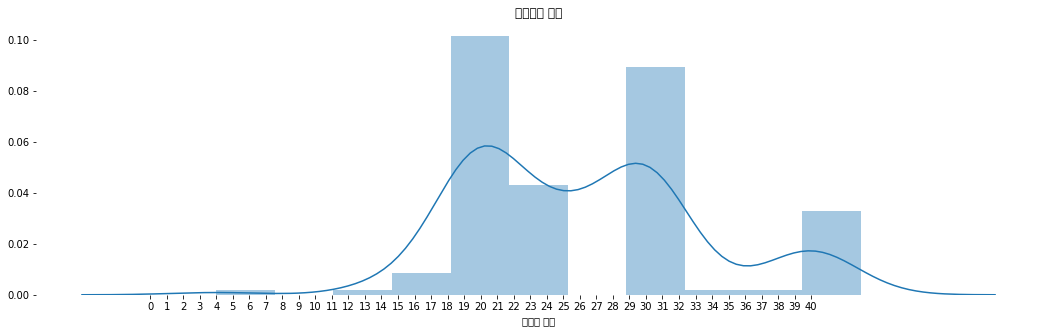

In [86]:
# 기존 스테이션의 거치대 수 분포
plt.figure(figsize=(18, 5))
sns.distplot(df_2['거치대 수량'])
plt.title("거치대수 분포")
plt.xticks(range(0, 41))
plt.box(False)
plt.show()

station_space = 25

- 전체 스테이션에 대해 거치대 수 분포를 분석해 보았을 때, 대부분 20개, 30개로 구성
- 모든 신규 스테이션에 대해 평균 값인 25개의 스테이션을 부여 예정
    - 거치대 수의 증가는 곧 자전거 배치량 증가로 이어짐
    - 거치대 25개로 고정된 신규 스테이션을 운용 후, 추후에 자전거 배치량을 조절을 고려

In [87]:
station_space = 25

In [104]:
# 신규 스테이션 데이터프레임
new_station = pd.DataFrame({
    '신규/기존' : '신규',
    'Station_ID' : new_station_id,
    '거치대 수량' : station_space,
    'xcord' : create_station['ycord'],
    'ycord' : create_station['xcord']
})
new_station.head()

,신규/기존,Station_ID,거치대 수량,xcord,ycord
0,신규,401,25,37.661,126.765
1,신규,402,25,37.654,126.770
2,신규,403,25,37.663,126.755
3,신규,404,25,37.661,126.757
4,신규,405,25,37.680,126.756


In [105]:
# 신규 스테이션에 동위치 추가

point= [Point(xy) for xy in zip(new_station.ycord, new_station.xcord)]  # 모든 스테이션의 (경도, 위도)를 가지고 있음

dong=[]
id=[]

for feature in geo_str_34['features']:                      
    polygon = shape(feature['geometry'])               # geostr내의 행정동 좌표값을 각각 가져와서 polygon 형태로 만듦
    for p in range(len(point)):
        if polygon.contains(point[p]):                    # 행정동이 스테이션의 (경도, 위도)를 가지고 있다면
            dong.append(feature['properties']['행정동명'])  # 그 행정동의 이름을 dong에 넣고
            id.append(new_station['Station_ID'][p])                # 스테이션의 이름을 id에 넣음
        
st_d=pd.DataFrame([dong,id])      # 스테이션별 좌표와, 스테이션이 위치한 동의 이름으로 df만듦
st_d=st_d.T
st_d.columns=['dong','Station_ID']
st_d.rename(columns={'dong':'동'}, inplace=True)
st_d
new_station = pd.merge(new_station, st_d, on='Station_ID')
new_station.rename(columns={'xcord':'X좌표', 'ycord':'Y좌표'}, inplace=True)
new_station.head()

,신규/기존,Station_ID,거치대 수량,X좌표,Y좌표,동
0,신규,401,25,37.661,126.765,장항2동
1,신규,402,25,37.654,126.770,장항2동
2,신규,403,25,37.663,126.755,대화동
3,신규,404,25,37.661,126.757,장항1동
4,신규,405,25,37.680,126.756,대화동


In [108]:
# 기존 스테이션 같은 폼으로 변형

station_dong.rename(columns={'RTN_STATION':'Station_ID',
                            'RTN_dong':'동'}, inplace=True)
existing_station = pd.merge(df_2, station_dong, on='Station_ID').drop(['STATION_NAME'], axis=1)
existing_station['신규/기존'] = '기존'
existing_station = existing_station[['신규/기존','Station_ID','거치대 수량','위도','경도','동']]
existing_station.rename(columns={'위도':'X좌표','경도':'Y좌표'}, inplace=True)
existing_station.head()

,신규/기존,Station_ID,거치대 수량,X좌표,Y좌표,동
0,기존,101,20,37.654775,126.834584,성사2동
1,기존,103,20,37.660442,126.840377,성사1동
2,기존,104,25,37.698523,126.766042,탄현동
3,기존,105,20,37.655244,126.839261,성사1동
4,기존,106,30,37.653410,126.842530,성사1동


In [112]:
# 기존 스테이션과 신규 스테이션을 합쳐서 출력

final_station = pd.concat([existing_station, new_station], axis=0)
final_station

,신규/기존,Station_ID,거치대 수량,X좌표,Y좌표,동
0,기존,101,20,37.654775,126.834584,성사2동
1,기존,103,20,37.660442,126.840377,성사1동
2,기존,104,25,37.698523,126.766042,탄현동
3,기존,105,20,37.655244,126.839261,성사1동
4,기존,106,30,37.653410,126.842530,성사1동
...,...,...,...,...,...,...
30,신규,431,25,37.661000,126.786000,마두1동
31,신규,432,25,37.664000,126.789000,마두1동
32,신규,433,25,37.676000,126.780000,정발산동
33,신규,434,25,37.660000,126.758000,장항1동


In [114]:
len(new_station)

35